# classification-19

## What's new:

1- https://chatgpt.com/c/692c6d11-40f8-8325-93c1-ff376d97d264


## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, Lambda
from tensorflow.keras import Input, layers, models, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, callbacks, losses, optimizers, metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime, timedelta
import joblib
import json
import os


2025-11-30 21:52:25.254656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 21:52:25.389403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

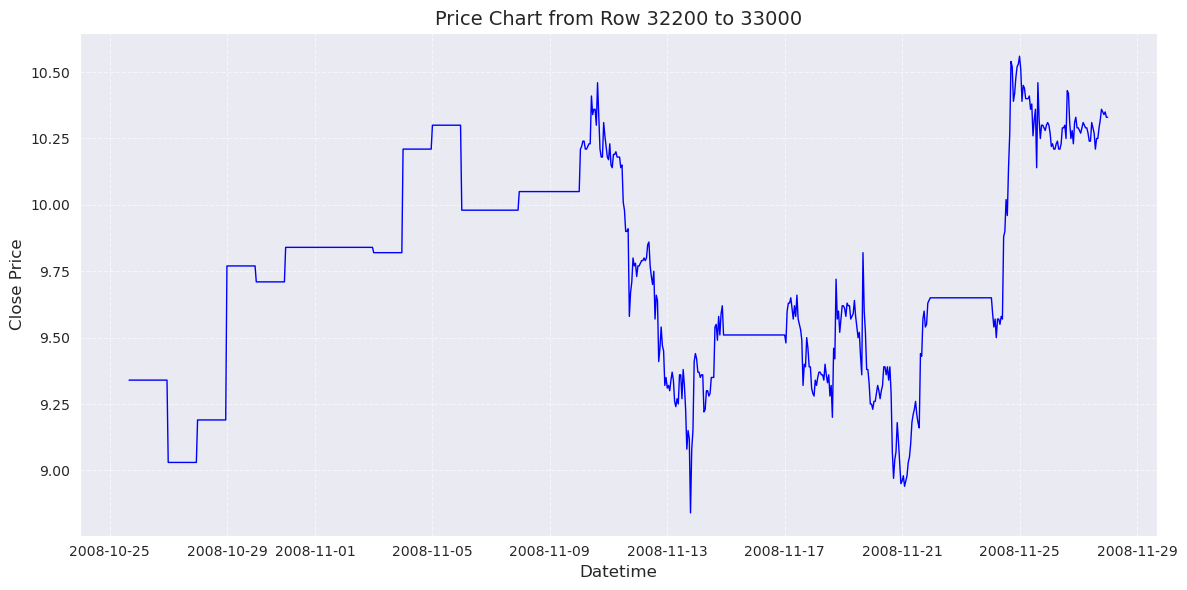

In [4]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [6]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [7]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [8]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [9]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



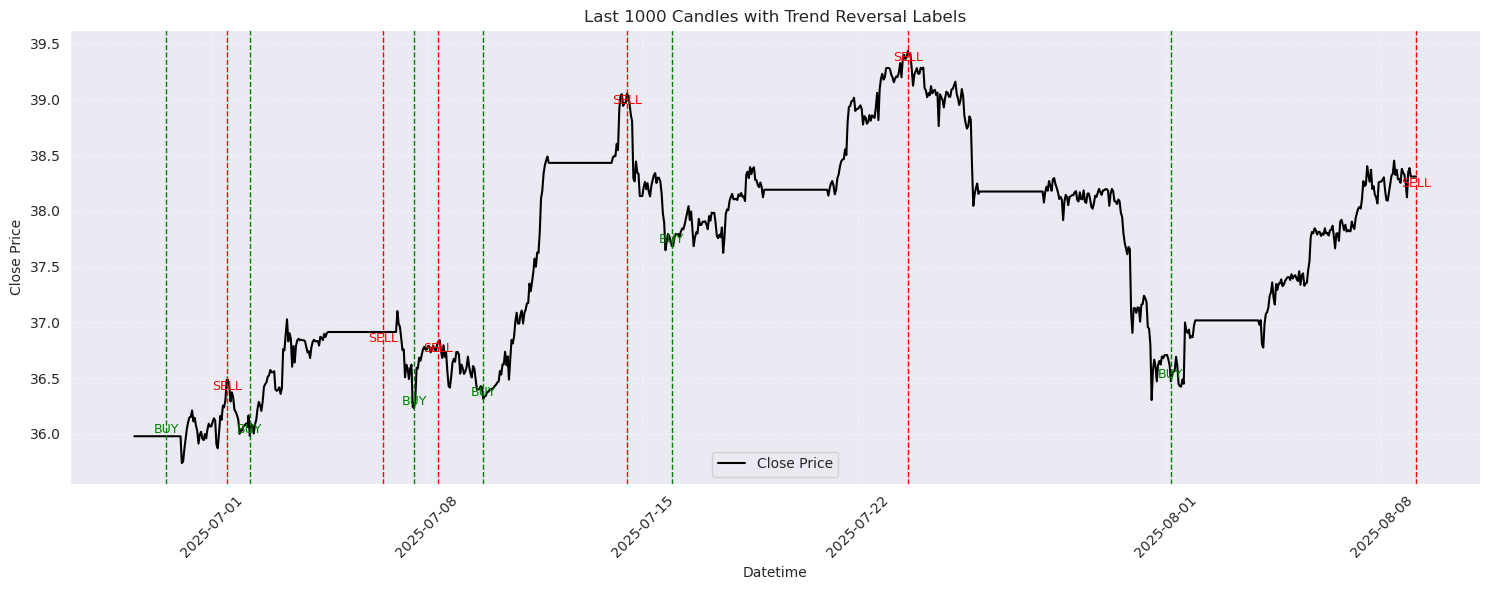

In [10]:
plot_labeled_candles(df_model)

In [11]:
# ---------------------------
# Configuration (from user)
# ---------------------------
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
N_FEATURES = len(FEATURES)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [12]:
# ---------------------------
# Helper: build supervised samples
# ---------------------------
def make_samples_from_df(df_source, features, label_column='Label',
                         window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON):
    """
    Produces X (num_samples, window_size, n_features) and y (num_samples, horizon)
    using df_source which must contain the label_column for rows used to produce labels.
    This function assumes df_source index is chronological.
    """
    arr_X = []
    arr_y = []
    # we'll generate samples where i = index of the last input candle in sequence
    max_i = len(df_source) - horizon  # because we need horizon labels after last input index
    for end_idx in range(window_size - 1, max_i):
        start_idx = end_idx - (window_size - 1)
        x_window = df_source.iloc[start_idx:end_idx + 1][features].values
        # labels are the next horizon rows' Label column
        y_window = df_source.iloc[end_idx + 1:end_idx + 1 + horizon][label_column].values
        # sanity: only include samples where y_window length == horizon
        if len(y_window) != horizon:
            continue
        arr_X.append(x_window)
        arr_y.append(y_window.astype(int))
    X = np.array(arr_X)  # shape (N, window_size, n_features)
    y = np.array(arr_y)  # shape (N, horizon)
    return X, y


In [13]:
# ---------------------------
# Prepare training/validation/test sets from df_model (chronological)
# ---------------------------
# NOTE: df_model must already exist in notebook (first 130,000 rows with 'Label' column)
N_rows = len(df_model)
print(f"df_model rows: {N_rows}")

# Create supervised samples from df_model
X_all, y_all = make_samples_from_df(df_model, FEATURES, label_column='Label',
                                    window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON)
print("All samples created:", X_all.shape, y_all.shape)

# Chronological split into 70% train / 15% val / 15% test (on the samples)
n_samples = X_all.shape[0]
train_end = int(n_samples * 0.70)
val_end = train_end + int(n_samples * 0.15)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

df_model rows: 146356
All samples created: (146287, 60, 5) (146287, 10)
Train/Val/Test shapes: (102400, 60, 5) (21943, 60, 5) (21944, 60, 5)


In [14]:
# ---------------------------
# Scale features (fit scaler on training input windows flattened across time)
# ---------------------------
# We'll scale per-feature using training set statistics (fit on flattened time axis)
scaler = StandardScaler()
# concatenate all timesteps of training data for scaler fitting
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)


def scale_X(X):
    shp = X.shape
    X_flat = X.reshape(-1, shp[-1])
    Xs = scaler.transform(X_flat).reshape(shp)
    return Xs


X_train_s = scale_X(X_train)
X_val_s = scale_X(X_val)
X_test_s = scale_X(X_test)

In [15]:
# ---------------------------
# Address class imbalance: create sample_weight per-sample-per-timestep
# (shape (num_samples, FORECAST_HORIZON))
# ---------------------------
# Compute class frequencies on training labels across all timesteps
unique, counts = np.unique(y_train.flatten(), return_counts=True)
freq = dict(zip(unique.tolist(), counts.tolist()))
print("Train label frequencies:", freq)

# If a class is missing in training (rare), add small epsilon to avoid division by zero
all_classes = [0, 1, 2]
class_counts = np.array([freq.get(c, 0) + 1e-6 for c in all_classes], dtype=np.float64)
class_freq = class_counts / class_counts.sum()
inv_freq = 1.0 / class_counts  # inverse counts
# normalize weights so that avg weight ~1.0 (optional)
inv_freq = inv_freq / np.mean(inv_freq)

weight_map = {c: inv_freq[i] for i, c in enumerate(all_classes)}
print("Class weight map (per class):", weight_map)


def make_sample_weights(y_array):
    # y_array shape: (num_samples, horizon) with integer labels 0/1/2
    sw = np.vectorize(lambda label: weight_map[int(label)])(y_array)
    return sw.astype(np.float32)  # shape (num_samples, horizon)


sample_weight_train = make_sample_weights(y_train)
sample_weight_val = make_sample_weights(y_val)

Train label frequencies: {0: 1010610, 1: 6700, 2: 6690}
Class weight map (per class): {0: np.float64(0.009904255768887859), 1: np.float64(1.4939313315092138), 2: np.float64(1.4961644127218983)}


In [16]:
# ---------------------------
# Build model: Conv1D -> BiLSTM -> TimeDistributed Dense(softmax)
# Output shape: (batch, FORECAST_HORIZON, 3)
# ---------------------------
n_features = len(FEATURES)
n_classes = 3


def build_model(window_size=WINDOW_SIZE, n_features=n_features, horizon=FORECAST_HORIZON, n_classes=n_classes):
    inp = layers.Input(shape=(window_size, n_features), name='input_window')
    # small feature extractor
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inp)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool1D(pool_size=2)(x)
    # BiLSTM to encode temporal features
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    # Expand to horizon timesteps and decode per-future-step
    x = layers.RepeatVector(horizon)(x)  # shape (batch, horizon, features)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
    out = layers.TimeDistributed(layers.Dense(n_classes, activation='softmax'), name='out')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model


model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_window (InputLayer)       │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (TimeDistributed)           │ (None, 10, 3)          │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,811 (1.46 MB)

 Trainable params: 383,811 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ---------------------------
# Compile model
# ---------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.SparseCategoricalCrossentropy(),  # expects integer labels shape (batch, horizon)
    metrics=['accuracy']
)

In [18]:
# ---------------------------
# Fit model with sample_weight (per-timestep)
# Note: Keras accepts sample_weight with same shape as labels (batch, time) for sequence losses.
# ---------------------------
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(
    X_train_s,  # shape (N_train, 60, n_features)
    y_train,  # shape (N_train, 10)
    sample_weight=sample_weight_train,  # shape (N_train, 10)
    validation_data=(X_val_s, y_val, sample_weight_val),
    epochs=200,
    batch_size=128,
    callbacks=[es, reduce_lr],
    verbose=1
)

Epoch 1/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.3856 - loss: 0.0310 - val_accuracy: 0.2976 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 2/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.3412 - loss: 0.0305 - val_accuracy: 0.2568 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 3/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.3331 - loss: 0.0302 - val_accuracy: 0.2368 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 4/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.3353 - loss: 0.0298 - val_accuracy: 0.2498 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 5/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.3389 - loss: 0.0292 - val_accuracy: 0.2578 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 6/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3513 - loss: 0.0271 - val_accuracy: 0.2592 - val_loss: 0.0481 - learning_rate: 5.0000e-04
Epoch 7/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy:

In [19]:
# ---------------------------
# Evaluate on test set
# ---------------------------
sample_weight_test = make_sample_weights(y_test)
test_res = model.evaluate(X_test_s, y_test, sample_weight=sample_weight_test, verbose=2)
print("Test loss/metrics:", test_res)


686/686 - 4s - 5ms/step - accuracy: 0.2446 - loss: 0.0374
Test loss/metrics: [0.037353239953517914, 0.244631826877594]


In [20]:
# ============================================================================
# PREDICTION SECTION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION ON UNSEEN DATA")
print("=" * 80)

given_time = "2025.08.13 21:00:00"
print(f"\nGiven time: {given_time}")

# Find the index of given_time in df (not df_model)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
given_idx = df[df['DATETIME'] == given_time].index[0]

print(f"Given time index in df: {given_idx}")

# Extract 60 candles ending at given_time
start_idx = given_idx - WINDOW_SIZE + 1
end_idx = given_idx + 1

input_df = df.iloc[start_idx:end_idx][['DATETIME'] + FEATURES].copy()
print(f"Input shape (before scaling): {input_df.shape}")

# Separate DATETIME from features for scaling
input_candles = input_df.copy()  # Keep for visualization (has DATETIME)
input_features_only = input_df[FEATURES].values  # Only features for model

# Scale using the same scaler from training (only the FEATURES columns)
input_scaled = scaler.transform(input_features_only)
input_scaled = input_scaled.reshape(1, WINDOW_SIZE, N_FEATURES)

# Predict
predictions_proba = model.predict(input_scaled, verbose=0)  # Shape: (1, 10, 3)
predictions_proba = predictions_proba[0]  # Shape: (10, 3)

# Get predicted classes
predicted_classes = np.argmax(predictions_proba, axis=1)

# Create forecast datetimes (next 10 hours after given_time)
given_datetime = pd.to_datetime(given_time)
forecast_datetimes = [given_datetime + pd.Timedelta(hours=i + 1) for i in range(FORECAST_HORIZON)]

# Create output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': predicted_classes,
    'prob_0': predictions_proba[:, 0],
    'prob_1': predictions_proba[:, 1],
    'prob_2': predictions_proba[:, 2]
})

print("\n" + "=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)
predicted_df



PREDICTION ON UNSEEN DATA

Given time: 2025.08.13 21:00:00
Given time index in df: 179469
Input shape (before scaling): (60, 6)

PREDICTION RESULTS


,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-13 22:00:00,1,0.233898,0.400345,0.365757
1,2025-08-13 23:00:00,1,0.224972,0.412242,0.362786
2,2025-08-14 00:00:00,1,0.221759,0.417101,0.361140
3,2025-08-14 01:00:00,1,0.221038,0.419538,0.359424
4,2025-08-14 02:00:00,1,0.222260,0.419886,0.357854
5,2025-08-14 03:00:00,1,0.225130,0.418585,0.356286
6,2025-08-14 04:00:00,1,0.229823,0.415685,0.354493
7,2025-08-14 05:00:00,1,0.237087,0.410712,0.352201
8,2025-08-14 06:00:00,1,0.248233,0.402810,0.348957
9,2025-08-14 07:00:00,1,0.264445,0.389364,0.346191


In [21]:
vals = predicted_df["forecast_class"].tolist()
print("[" + " ".join(str(x) for x in vals) + "]")


def filter_forecast_classes(fc):
    fc = fc.copy()
    n = len(fc)

    # ------------------------------------------
    # Rule A: Keep only last in consecutive runs
    # ------------------------------------------
    i = 0
    while i < n:
        if fc[i] in [1, 2]:
            val = fc[i]
            start = i
            end = i
            while end + 1 < n and fc[end + 1] == val:
                end += 1
            # Keep only the last occurrence
            for k in range(start, end):
                fc[k] = 0
            i = end
        i += 1

    # ---------------------------------------------------------
    # Rule B & C: If val (1 or 2) appears, then zeros, then val
    # ---------------------------------------------------------
    for val in [1, 2]:
        last_pos = None
        for i in range(n):
            if fc[i] == val:
                if last_pos is not None:
                    # Remove the old one (set to 0)
                    fc[last_pos] = 0
                last_pos = i
            elif fc[i] != 0:
                # reset tracking when 0-block is broken by other class
                last_pos = None

    return fc


filtered = filter_forecast_classes(predicted_df["forecast_class"].tolist())
print("[" + " ".join(str(x) for x in filtered) + "]")

[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1]


In [22]:
# -----------------------------
# Part 3: Apply filtering
# -----------------------------

# Overwrite forecast_class (replace old with new)
predicted_df["forecast_class"] = filtered

# Show full dataframe
predicted_df

,DATETIME,forecast_class,prob_0,prob_1,prob_2
0,2025-08-13 22:00:00,0,0.233898,0.400345,0.365757
1,2025-08-13 23:00:00,0,0.224972,0.412242,0.362786
2,2025-08-14 00:00:00,0,0.221759,0.417101,0.361140
3,2025-08-14 01:00:00,0,0.221038,0.419538,0.359424
4,2025-08-14 02:00:00,0,0.222260,0.419886,0.357854
5,2025-08-14 03:00:00,0,0.225130,0.418585,0.356286
6,2025-08-14 04:00:00,0,0.229823,0.415685,0.354493
7,2025-08-14 05:00:00,0,0.237087,0.410712,0.352201
8,2025-08-14 06:00:00,0,0.248233,0.402810,0.348957
9,2025-08-14 07:00:00,1,0.264445,0.389364,0.346191


# plot section

In [23]:
# --------------------------
# === Visualization Block ===
# --------------------------

# historical_df originally has no DATETIME, so add it
historical_df = input_df.tail(4).copy()


In [24]:
historical_df

,DATETIME,OPEN,HIGH,LOW,CLOSE,TICKVOL
179466,2025-08-13 18:00:00,38.503,38.511,38.400,38.458,1833.0
179467,2025-08-13 19:00:00,38.457,38.502,38.446,38.483,967.0
179468,2025-08-13 20:00:00,38.483,38.572,38.468,38.479,1006.0
179469,2025-08-13 21:00:00,38.480,38.487,38.440,38.476,897.0


In [25]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()



In [26]:
actual_future_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
179469,2025-08-13 21:00:00,2025.08.13,21:00:00,38.480,38.487,38.440,38.476,897.0,0.0,11.0
179470,2025-08-13 22:00:00,2025.08.13,22:00:00,38.476,38.549,38.456,38.539,856.0,0.0,11.0
179471,2025-08-13 23:00:00,2025.08.13,23:00:00,38.526,38.541,38.483,38.493,419.0,0.0,14.0
179472,2025-08-14 00:00:00,NaN,NaN,38.526,38.541,38.483,38.493,0.0,0.0,14.0
179473,2025-08-14 01:00:00,2025.08.14,01:00:00,38.533,38.538,38.506,38.519,395.0,0.0,21.0
179474,2025-08-14 02:00:00,2025.08.14,02:00:00,38.514,38.532,38.487,38.518,522.0,0.0,21.0
179475,2025-08-14 03:00:00,2025.08.14,03:00:00,38.517,38.587,38.517,38.565,1308.0,0.0,21.0
179476,2025-08-14 04:00:00,2025.08.14,04:00:00,38.565,38.614,38.516,38.610,1844.0,0.0,21.0
179477,2025-08-14 05:00:00,2025.08.14,05:00:00,38.610,38.726,38.610,38.690,1652.0,0.0,21.0
179478,2025-08-14 06:00:00,2025.08.14,06:00:00,38.689,38.691,38.540,38.561,1569.0,0.0,21.0


In [27]:
# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



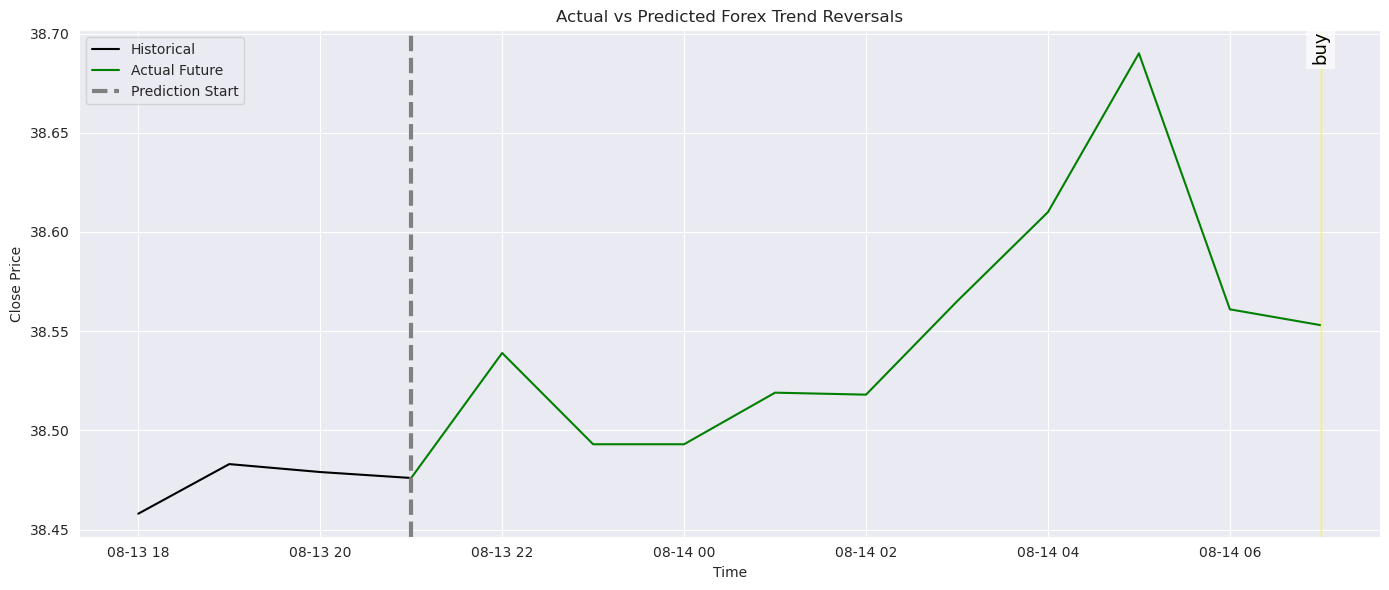

In [28]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [29]:
# 11- Save Model with Comprehensive Report
from datetime import datetime
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")

# 11-4 Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 11-5 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 11-6 Save full history as JSON so it can be reloaded later
history_json_path = os.path.join(log_dir, 'history.json')
with open(history_json_path, 'w') as f:
    json.dump(history.history, f)

print(f"Full history object saved to: {history_json_path}")

# 11-7 Save training loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-8 Save accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_accuracy.png'))
plt.close()

# 11-9 Evaluate on validation set (NO ONE-HOT)
eval_results = model.evaluate(X_val, y_val, verbose=0)

final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = eval_results[0]
final_val_acc = eval_results[1]

# 11-10 Generate detailed predictions for per-class analysis
print("\n[GENERATING DETAILED METRICS]")
y_val_pred_proba = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=-1)

# Flatten predictions and true labels for sklearn metrics
y_val_pred_flat = y_val_pred.flatten()
y_val_true_flat = y_val.flatten()

# Generate classification report
class_report = classification_report(
    y_val_true_flat,
    y_val_pred_flat,
    target_names=['Class 0 (No Signal)', 'Class 1 (Buy)', 'Class 2 (Sell)'],
    digits=4
)

# Generate confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat)

# Calculate class distributions
train_class_dist = np.bincount(y_train.flatten()) / len(y_train.flatten()) * 100
val_class_dist = np.bincount(y_val.flatten()) / len(y_val.flatten()) * 100
test_class_dist = np.bincount(y_test.flatten()) / len(y_test.flatten()) * 100

# Get class weights used during training
labels_flat = y_train.flatten()
classes = np.unique(labels_flat)
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=classes, y=labels_flat)
class_weight_dict = {i: weights[i] for i in range(len(weights))}

# Calculate training time from history
epochs_trained = len(history.history['loss'])

# 11-11 Save confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.close()

# 11-12 Save per-class performance plot
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_val_true_flat, y_val_pred_flat, average=None
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1-Score']
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    axes[idx].bar(['Class 0', 'Class 1', 'Class 2'], metric, color=colors_bar)
    axes[idx].set_title(f'{name} by Class')
    axes[idx].set_ylim([0, 1.1])
    axes[idx].set_ylabel(name)
    for i, v in enumerate(metric):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'per_class_metrics.png'), dpi=150, bbox_inches='tight')
plt.close()

# 11-12 Create comprehensive report
comprehensive_report = f"""
{'=' * 80}
MODEL TRAINING REPORT
{'=' * 80}
Timestamp: {timestamp}
Model Path: {model_path}
Scaler Path: {scaler_path}

{'=' * 80}
DATA CONFIGURATION
{'=' * 80}
Total Samples in df_model: {len(df_model):,}

Training Samples: {len(X_train):,} ({len(X_train) / len(df_model) * 100:.1f}%)
Validation Samples: {len(X_val):,} ({len(X_val) / len(df_model) * 100:.1f}%)
Test Samples: {len(X_test):,} ({len(X_test) / len(df_model) * 100:.1f}%)

CLASS DISTRIBUTION:
Training Set:
  - Class 0 (No Signal): {train_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {train_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {train_class_dist[2]:.2f}%

Validation Set:
  - Class 0 (No Signal): {val_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {val_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {val_class_dist[2]:.2f}%

Test Set:
  - Class 0 (No Signal): {test_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {test_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {test_class_dist[2]:.2f}%

FEATURE CONFIGURATION:
Features Used: {', '.join(FEATURES)}
Window Size: {WINDOW_SIZE} hours
Forecast Horizon: {FORECAST_HORIZON} hours

{'=' * 80}
TRAINING CONFIGURATION
{'=' * 80}
Optimizer: Adam (initial lr=0.001)
Loss Function: Categorical Crossentropy
Batch Size: 64
Early Stopping: patience=15, monitor=val_loss
Reduce LR: patience=7, factor=0.5

CLASS WEIGHTS (for handling imbalance):
  Class 0: {class_weight_dict[0]:.4f}
  Class 1: {class_weight_dict[1]:.4f}
  Class 2: {class_weight_dict[2]:.4f}

TRAINING PROGRESS:
Epochs Trained: {epochs_trained} / 100
Best Validation Loss Epoch: {np.argmin(history.history['val_loss']) + 1}

{'=' * 80}
MODEL ARCHITECTURE
{'=' * 80}
Total Parameters: {model.count_params():,}
Trainable Parameters: {sum([np.prod(v.shape) for v in model.trainable_weights]):,}

{'=' * 80}
OVERALL METRICS
{'=' * 80}
Final Training Loss: {final_train_loss:.6f}
Final Training Accuracy: {final_train_acc:.6f}
Final Validation Loss: {final_val_loss:.6f}
Final Validation Accuracy: {final_val_acc:.6f}

{'=' * 80}
PER-CLASS PERFORMANCE (Validation Set)
{'=' * 80}
{class_report}

{'=' * 80}
CONFUSION MATRIX (Validation Set)
{'=' * 80}
                Predicted
              Class 0  Class 1  Class 2
Actual Class 0  {cm[0][0]:6d}    {cm[0][1]:6d}    {cm[0][2]:6d}
       Class 1  {cm[1][0]:6d}    {cm[1][1]:6d}    {cm[1][2]:6d}
       Class 2  {cm[2][0]:6d}    {cm[2][1]:6d}    {cm[2][2]:6d}

{'=' * 80}
MINORITY CLASS ANALYSIS
{'=' * 80}
Class 1 (Buy Reversal):
  Total Instances: {support[1]}
  Correctly Predicted: {cm[1][1]}
  Missed (False Negatives): {cm[1][0] + cm[1][2]}
  False Positives: {cm[0][1] + cm[2][1]}

Class 2 (Sell Reversal):
  Total Instances: {support[2]}
  Correctly Predicted: {cm[2][2]}
  Missed (False Negatives): {cm[2][0] + cm[2][1]}
  False Positives: {cm[0][2] + cm[1][2]}

{'=' * 80}
FILES SAVED
{'=' * 80}
- Model: {model_filename}
- Scaler: scaler_{timestamp}.pkl
- Training History: training_history.csv
- Training Loss Plot: training_loss.png
- Training Accuracy Plot: training_accuracy.png
- Confusion Matrix: confusion_matrix.png
- Per-Class Metrics: per_class_metrics.png
- This Report: comprehensive_report.txt

{'=' * 80}
"""

# 11-13 Save comprehensive report
report_path = os.path.join(log_dir, 'comprehensive_report.txt')
with open(report_path, 'w') as f:
    f.write(comprehensive_report)

# Also save model summary separately
summary_path = os.path.join(log_dir, 'model_architecture.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Print the comprehensive report to console
print(comprehensive_report)

print(f"\n{'=' * 80}")
print(f"[SAVE COMPLETE]")
print(f"{'=' * 80}")
print(f"All files saved in: {log_dir}")
print(f"\nKey files:")
print(f"  - Comprehensive Report: {report_path}")
print(f"  - Model Architecture: {summary_path}")
print(f"  - Confusion Matrix: {os.path.join(log_dir, 'confusion_matrix.png')}")
print(f"  - Per-Class Metrics: {os.path.join(log_dir, 'per_class_metrics.png')}")


[SAVING MODEL]
Model saved to: saved_models/model_20251130_220009.keras
Scaler saved to: saved_models/scaler_20251130_220009.pkl
Training history saved
Full history object saved to: saved_models/model_20251130_220009_logs/history.json

[GENERATING DETAILED METRICS]



MODEL TRAINING REPORT
Timestamp: 20251130_220009
Model Path: saved_models/model_20251130_220009.keras
Scaler Path: saved_models/scaler_20251130_220009.pkl

DATA CONFIGURATION
Total Samples in df_model: 146,356

Training Samples: 102,400 (70.0%)
Validation Samples: 21,943 (15.0%)
Test Samples: 21,944 (15.0%)

CLASS DISTRIBUTION:
Training Set:
  - Class 0 (No Signal): 98.69%
  - Class 1 (Buy Reversal): 0.65%
  - Class 2 (Sell Reversal): 0.65%

Validation Set:
  - Class 0 (No Signal): 98.15%
  - Class 1 (Buy Reversal): 0.92%
  - Class 2 (Sell Reversal): 0.93%

Test Set:
  - Class 0 (No Signal): 98.26%
  - Class 1 (Buy Reversal): 0.87%
  - Class 2 (Sell Reversal): 0.87%

FEATURE CONFIGURATION:
Features Used: OPEN, HIGH, LOW, CLOSE, TICKVOL
Window Size: 60 hours
Forecast Horizon: 10 hours

TRAINING CONFIGURATION
Optimizer: Adam (initial lr=0.001)
Loss Function: Categorical Crossentropy
Batch Size: 64
Early Stopping: patience=15, monitor=val_loss
Reduce LR: patience=7, factor=0.5

CLASS WEI

In [ ]:
# 1- Load model
model_path = 'saved_models/model_20251130_213117.keras'
model = keras.models.load_model(model_path)

# 2- Load scaler
scaler_path = 'saved_models/scaler_20251130_213117.pkl'
scaler = joblib.load(scaler_path)

# 3- Load history JSON
log_dir = 'saved_models/model_20251130_213117_logs'
history_json_path = os.path.join(log_dir, 'history.json')

with open(history_json_path, 'r') as f:
    history_dict = json.load(f)


# create history-like object
class ReloadedHistory:
    def __init__(self, hdict):
        self.history = hdict


history = ReloadedHistory(history_dict)

# Now you can access history just like before
print(history.history.keys())
print(history.history['loss'][:5])
